# Opdracht schilderijen

In [1]:
from tensorflow import keras
from keras import layers
from keras.utils import image_dataset_from_directory
import os
import numpy as np

# importeren van zelf geschreven callback
from Callbacks.RealTimePlotCallback import RealTimePlotCallback

In [2]:
while os.getcwd() != "C:\\My Projects\\Opdracht-schilders":
    os.chdir('..')

os.getcwd()

'C:\\My Projects\\Opdracht-schilders'

Inlezen van de train-, validatie- en testdata op basis van de verschillende directories waarin we de data hebben opgesplitst. We lezen deze in met behulp van de geïmporteerde image_dataset_from_directory functie van keras.utils.

In [2]:
train_data = image_dataset_from_directory("datasets/dataset/train", image_size=(180, 180))
val_data = image_dataset_from_directory("datasets/dataset/validation", image_size=(180, 180))
test_data = image_dataset_from_directory("datasets/dataset/test", image_size=(180, 180))

Found 4590 files belonging to 5 classes.
Found 1525 files belonging to 5 classes.
Found 1530 files belonging to 5 classes.


## Modellen uit boek

### Eenvoudig convnet (zonder data augmentation)

#### Listing 8.7 (p215)

Zoals in de opgave gevraagd wordt, zal ik beginnen met het convnet uit Listing 8.7 (p215) van de Cats & Dogs oefening. Ik maak de nodige aanpassingen aan het model zodat deze gebruikt kan worden voor deze opdracht. Namelijk het aantal units van de output Dense layer verander ik naar 4, omdat we met 4 klassen werken (4 schilders). Ik verander ook de activatiefunctie van sigmoid naar softmax, omdat we niet meer met binaire classificatie werken maar met multiclass single-label classification. Ik maak ook gebruik van de sparse_categorical_crossentropy loss-functie in plaats van binary_crossentropy voor dezelfde reden.

Ik maak deze aanpassingen voor ieder model in deze notebook.

In [3]:
input_layer = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(input_layer)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(5, activation="softmax")(x)  # 5 because we have 5 classes (0 through 4)

model = keras.Model(inputs=input_layer, outputs=outputs)

# Return the compiled model
model.compile(
  loss="sparse_categorical_crossentropy",
  optimizer=keras.optimizers.RMSprop(),
  metrics=["accuracy"],
)

Ik maak gebruik van verschillende callbacks tijdens het fitten van mijn model.
 - **ModelCheckpoint** om het beste model op te slaan op basis van de validation loss. Deze modellen worden opgeslagen in de 'models' directory.
 - **EarlyStopping** om het fitten vervroegd te stoppen wanneer de validation accuracy niet meer verbeterd. Ik heb hiervoor een patience van 10 epochs (10% van 100 epochs) ingesteld, een hogere patience voorkomt ook dat we een undergefit model bekomen. Wanneer de validation accuracy al 10 epochs niet meer verbeterd, zal het trainen stoppen. Zo wordt er gestopt wanneer er overgefit wordt en wordt er niet nodeloos verder getraind.
 - **RealTimePlotCallback**, een zelfgeschreven callback om de training en vaidatie accuracy en loss na iedere epoch te plotten. (U vindt de code hiervan in 'Callbacks' folder.)

<Figure size 640x480 with 0 Axes>

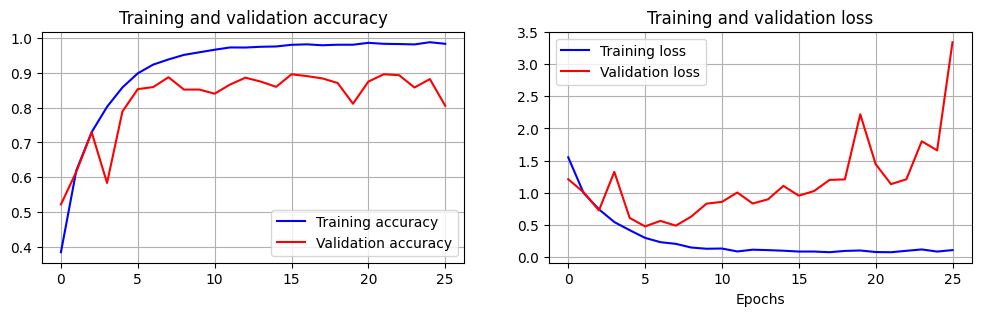

training loss: 0.11051104217767715
validation loss: 3.338704824447632
training accuracy: 0.9832243919372559
validation accuracy: 0.8052458763122559

epochs: 26

144/144 [==============================] - 8s 56ms/step - loss: 0.1105 - accuracy: 0.9832 - val_loss: 3.3387 - val_accuracy: 0.8052


In [4]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="3. Modellen uit boek/models/convnet_p215.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_loss"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    callbacks=callbacks_list
)


We zien op de grafiek van de loss dat het model na 5 epochs begint te overfitten. Dit is te herkennen aan dat de training loss en validatie loss uit elkaar beginnen te lopen. Na epoch 5 begint de loss van de validatie set te stijgen.

### Eenvoudig convnet met data augmentation

#### Listing 8.14 (p221) & 8.16 (p223)

In [6]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
)

input_layer = keras.Input(shape=(180, 180, 3))
x = data_augmentation(input_layer)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)  # 5 because we have 5 classes (0 through 4)

model = keras.Model(inputs=input_layer, outputs=outputs)

# Return the compiled model
model.compile(
  loss="sparse_categorical_crossentropy",
  optimizer=keras.optimizers.RMSprop(),
  metrics=["accuracy"],
)

<Figure size 640x480 with 0 Axes>

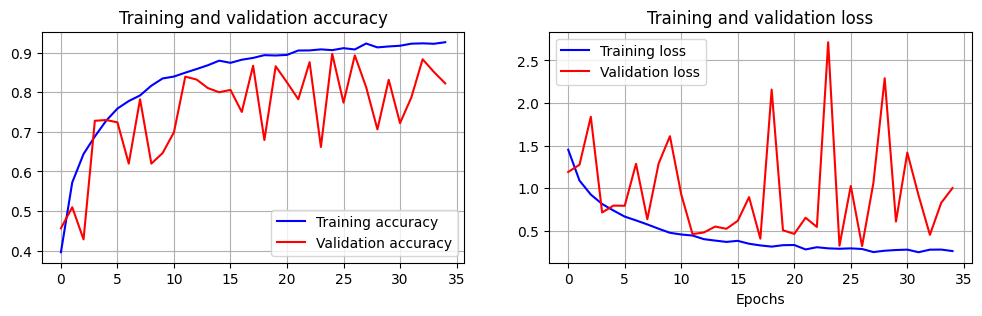

training loss: 0.2644869089126587
validation loss: 1.004054307937622
training accuracy: 0.9263616800308228
validation accuracy: 0.822295069694519

epochs: 35

144/144 [==============================] - 49s 340ms/step - loss: 0.2645 - accuracy: 0.9264 - val_loss: 1.0041 - val_accuracy: 0.8223


In [7]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="3. Modellen uit boek/models/convnet_p223_data_augmentation.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_loss"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
    train_data,
    epochs=100,
    validation_data=val_data,
    callbacks=callbacks_list
)

Door de data augmentation kunnen we langer trainen. We zien wel dat de validatie loss veel op en neer springt, maar deze keert daarna wel terug naar ongeveer hetzelfde niveau als de training loss.

### Feature extraction met VGG16

#### Listing 8.19 (p227) en 8.20 (p229)

In [8]:
conv_base = keras.applications.vgg16.VGG16(
 weights="imagenet",
 include_top=False,
 input_shape=(180, 180, 3))


def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_data)
val_features, val_labels = get_features_and_labels(val_data)
test_features, test_labels = get_features_and_labels(test_data)

1/1 [==============================] - 3s 3s/step


Ik vraag de shape van de train features op, deze wordt dan als input shape gegeven.

In [9]:
train_features.shape

(4590, 5, 5, 512)

#### Listing 8.21 (p229)

In [10]:
inputs = keras.Input(shape=(5, 5, 512)) # train_features.shape
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)  # 4 because we have 4 classes (0 through 3)
model = keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

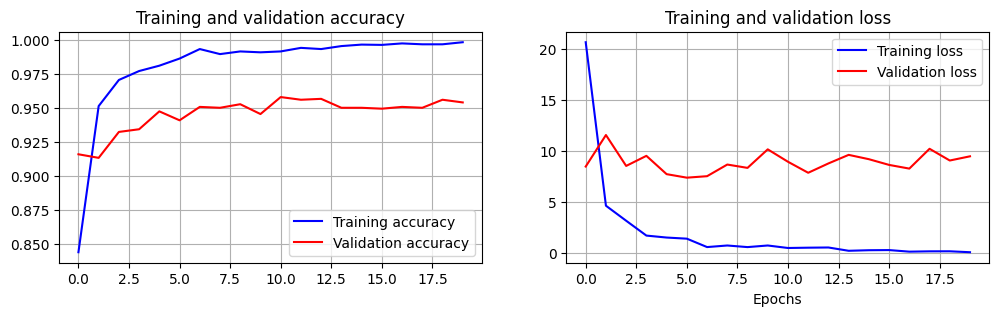

training loss: 0.07623918354511261
validation loss: 9.481322288513184
training accuracy: 0.9982571005821228
validation accuracy: 0.9540983438491821

epochs: 20

144/144 [==============================] - 1s 8ms/step - loss: 0.0762 - accuracy: 0.9983 - val_loss: 9.4813 - val_accuracy: 0.9541


In [11]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="3. Modellen uit boek/models/feature_extraction_VGG16.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_loss"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_features, train_labels,
         epochs=20,
         validation_data=(val_features, val_labels),
         callbacks=callbacks_list)

Dit is tot nu toe het beste resultaat van de modellen uit het boek. Het heeft wel een hoge validatie loss, tussen 7 en 10.

### Feature extraction met VGG16 (nu met data augmentation)

#### Listing 8.23 (p231) & 8.25 (p232)

In [12]:
conv_base = keras.applications.vgg16.VGG16(
 weights="imagenet",
 include_top=False)
conv_base.trainable = False


data_augmentation = keras.Sequential(
     [
     layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),
     ]
)
input_layer = keras.Input(shape=(180, 180, 3))
x = data_augmentation(input_layer)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(input_layer, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

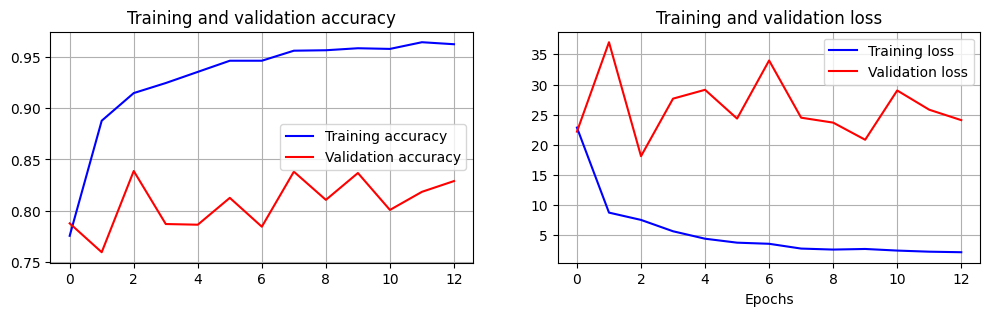

training loss: 2.1935789585113525
validation loss: 24.093704223632812
training accuracy: 0.9625272154808044
validation accuracy: 0.8288524746894836

epochs: 13

144/144 [==============================] - 54s 371ms/step - loss: 2.1936 - accuracy: 0.9625 - val_loss: 24.0937 - val_accuracy: 0.8289


In [13]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="3. Modellen uit boek/models/feature_extraction_VGG16_data_augmentation.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_loss"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_data,
         epochs=50,
         validation_data=val_data,
         callbacks=callbacks_list)

Met data augmentation krijgen we slechtere resultaten en de loss van de validatieset is bijna verdubbeld.

### Finetuning van VGG16 conv base

#### Listing 8.27 (p236) & 8.28 (p236)

<Figure size 640x480 with 0 Axes>

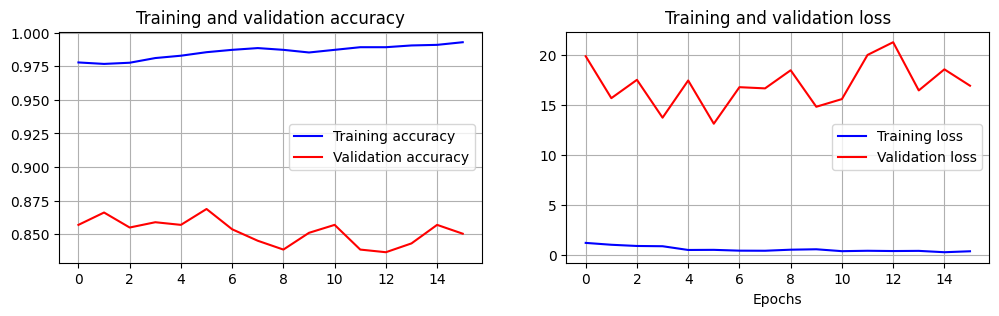

training loss: 0.3365519344806671
validation loss: 16.92287254333496
training accuracy: 0.9928104281425476
validation accuracy: 0.8504918217658997

epochs: 16

144/144 [==============================] - 63s 433ms/step - loss: 0.3366 - accuracy: 0.9928 - val_loss: 16.9229 - val_accuracy: 0.8505


In [14]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False


model.compile(loss="sparse_categorical_crossentropy",
     optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
     metrics=["accuracy"])

callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="3. Modellen uit boek/models/finetuned_conv_base_VGG16.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_loss"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
     train_data,
     epochs=30,
     validation_data=val_data,
     callbacks=callbacks_list)

Na de fine-tuning bekomen we ongeveer eenzelfde model als voor de fine-tuning.